# Analyza EMM ve smeru $xz$ vcetne nejistot

In [21]:
# Setup some Jupyter env features
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# data import

import numpy as np

fotkor = np.genfromtxt("sikmy_EMM_10_03_2020_part1_delim.txt", delimiter="\t")[:,:-1]
voltages = np.genfromtxt("sikmy_EMM_10_03_2020_part1_voltages.txt", delimiter="\t")

# pomocne promene
fotkor_shape = np.shape(fotkor)

# parametry odecitani foton-korelacnich dat
t_res = 256e-12  # casove rozliseni histogramu v s
t_measure = 150 # doba nacitani dat v s

# casova skala foton-kor. dat
t_scale = np.array( range(0,fotkor_shape[0]) ) *t_res

#---------- odecet pozadi
background_photocounts = 400 # ph/s  tyto fotony jsou rovnomerne rozdeleny v prubehu RF periody
bg_ph_sum = background_photocounts * t_measure  # celkovy pocet fotonu pozadi za cas mereni
last_bin_ratio = fotkor[fotkor_shape[0]-2, 5] / fotkor[fotkor_shape[0]-3, 5]  # pomer mezi county v poslednim/predposlednim binu
bg_ph_per_bin = bg_ph_sum/(fotkor_shape[0]-2 + last_bin_ratio)

fotkor[:fotkor_shape[0]-2,:] = fotkor[:fotkor_shape[0]-2,:] - bg_ph_per_bin 
fotkor[fotkor_shape[0]-2,:] = fotkor[fotkor_shape[0]-2,:] - bg_ph_per_bin * last_bin_ratio
# ------------------------------

In [23]:
# plot dat
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams

rcParams["font.size"] = 14
rcParams["mathtext.fontset"] = "cm"
rcParams["mathtext.rm"] = "serif"
rcParams["text.usetex"] = "true";
rc('text', usetex=True)

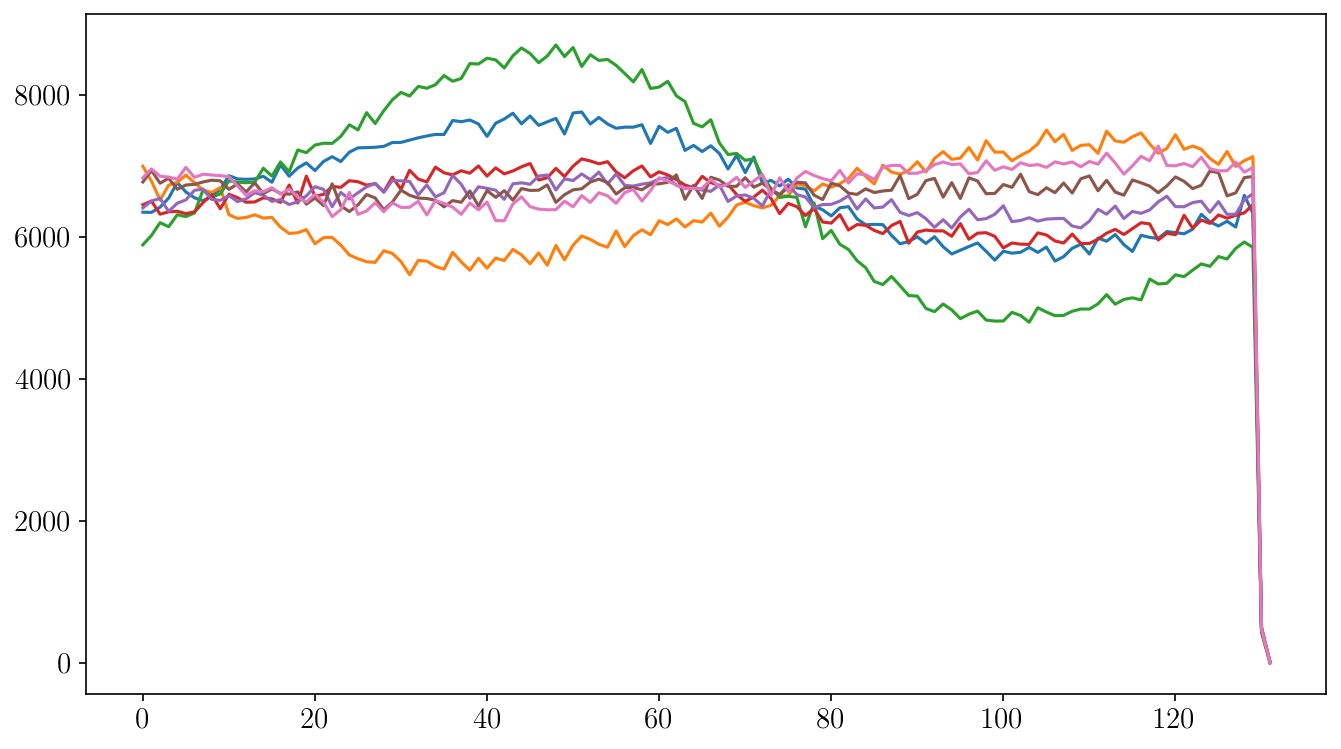

In [24]:
my_dpi = 150
siz = 100
sizex = 16*siz
sizey = 9*siz

plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
plt.plot(fotkor)

vyber histogramu s nejmensim EMM

In [25]:
# odhad periody triggeru
T_trig = ( fotkor[fotkor_shape[0]-2, 5] / fotkor[fotkor_shape[0]-3, 5] )* t_res + t_scale[fotkor_shape[0]-2]

T_trig_sigma = t_res
# frekvence buzeni pasti

drive_freq = 1/T_trig
drive_freq_sigma = 1/T_trig**2 *T_trig_sigma
Omega = 2*np.pi * drive_freq
Omega_sigma = 2*np.pi * drive_freq_sigma
drive_freq

30032822.857731443

In [32]:
# funkce vracejici residua
def fit_resid(x, Omega, S, time_step):
    # x = [S_0, Delta S, phi]
    len_S = len(S)
    #print(len_S)
    S_fit = x[0] + x[1] * np.cos(Omega * time_step * np.arange(0, len_S) + x[2])
    return S - S_fit

def fit_func(x, Omega, time_points):
    return x[0] + x[1] * np.cos(Omega * time_points + x[2])

In [33]:
from scipy.optimize import least_squares
# cyklus fitujici vsechny foton-korelacni data

x = np.zeros( (3,fotkor_shape[1]) )
DeltaS_S_ratio = []
for i in range(fotkor_shape[1]):
    x0 = [fotkor[:fotkor_shape[0]-2,i].mean(), 0.5* ( fotkor[:fotkor_shape[0]-2,i].max()
        -fotkor[:fotkor_shape[0]-2,i].min() ), 1.5]

    #fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,0], t_res) , method="lm", ftol=1e-10)
    fit = least_squares(fit_resid,x0, args=(Omega, fotkor[:fotkor_shape[0]-2,i], t_res) , ftol=1e-10, xtol=1e-10)
    
    x[:,i] = fit.x
    DeltaS_S_ratio.append(x[1,i]/x[0,i]  )
    

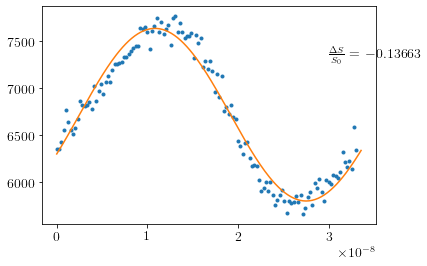

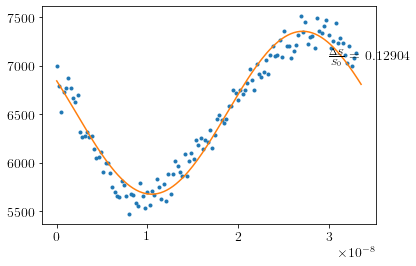

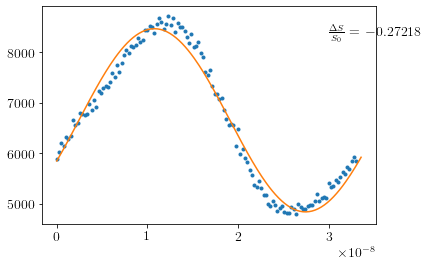

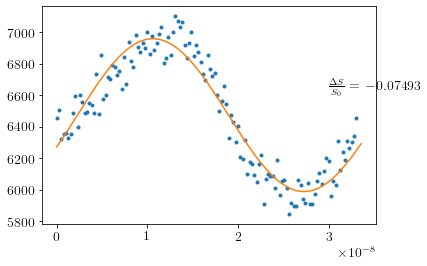

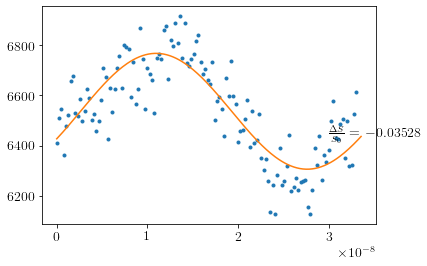

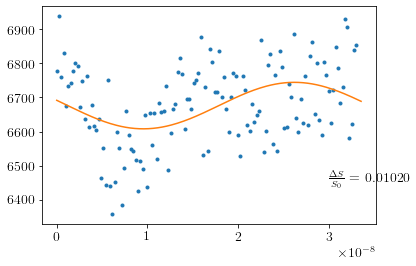

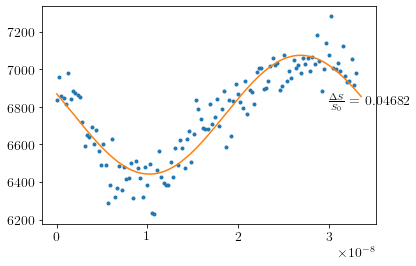

In [34]:
# my_dpi = 150
# siz = 100
# sizex = 16*siz
# sizey = 9*siz
# plot techto fitu
time_fit = np.linspace(0, t_scale.max(), 200)


for i in range(fotkor_shape[1]):
    
    fotkor_fit = fit_func(x[:,i], Omega, time_fit)
    
    plt.figure()
#     plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
    plt.plot(t_scale[:fotkor_shape[0]-2],fotkor[:fotkor_shape[0]-2,i],'.')
    plt.plot(time_fit, fotkor_fit)
    text = r'$\frac{\Delta S}{S_0}  = \,\,$' + r'${:.5f}$'.format(x[1,i]/x[0,i])
    plt.text(3e-8, fotkor[:,i].max()-500,text) 

nejmensi EMM ma 5tka

In [35]:
x0 = [fotkor[:fotkor_shape[0]-2,5].mean(), 0.5* ( fotkor[:fotkor_shape[0]-2,5].max()
    -fotkor[:fotkor_shape[0]-2,5].min() ), 1.5]

#fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,0], t_res) , method="lm", ftol=1e-10)
fit = least_squares(fit_resid,x0, args=(Omega, fotkor[:fotkor_shape[0]-2,5], t_res) , ftol=1e-10, xtol=1e-10)

In [36]:
# odectu sinusovky od dat
fotkor_noMM = fotkor[1:fotkor_shape[0]-2,5] - (fit_func(fit.x, Omega, t_scale[1:fotkor_shape[0]-2])) # data po odecteni modulace

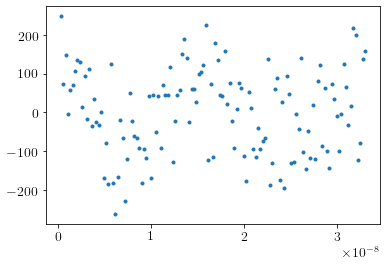

In [37]:
plt.plot(t_scale[1:fotkor_shape[0]-2],fotkor_noMM, '.')

Vypada to, ze tam je nejaka vyssi frekvence

In [38]:
hist_sigma = np.std(fotkor_noMM)
hist_sigma

110.27222819643478

to stejne zkusim pro jine data

In [39]:
k = 6
x0 = [fotkor[:fotkor_shape[0]-2,k].mean(), 0.5* ( fotkor[:fotkor_shape[0]-2,k].max()
    -fotkor[:fotkor_shape[0]-2,k].min() ), 1.5]

#fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,0], t_res) , method="lm", ftol=1e-10)
fit = least_squares(fit_resid,x0, args=(Omega, fotkor[:fotkor_shape[0]-2,k], t_res) , ftol=1e-10, xtol=1e-10)
# odectu sinusovky od dat
fotkor_noMM = fotkor[1:fotkor_shape[0]-2,k] - (fit_func(fit.x, Omega, t_scale[1:fotkor_shape[0]-2])) # data po odecteni modulace
np.std(fotkor_noMM)

97.18499774314243

Vychazi kolem stovky

## Fitovani

In [40]:
# residua vcetne vah
# funkce vracejici residua
def fit_resid_weight(x,W_vec, Omega, S, time_step):
    # x = [S_0, Delta S, phi]
    # W_vec .. vektor vah prislusejicich jednotlivym bodum
    len_S = len(S)
    #print(len_S)
    S_fit = x[0] + x[1] * np.cos(Omega * time_step * np.arange(0, len_S) + x[2])
    return( np.sqrt(W_vec) * (S - S_fit) )



In [59]:
#from scipy.optimize import least_squares
# cyklus fitujici vsechny foton-korelacni data

x = np.zeros( (3,fotkor_shape[1]) )
DeltaS_S_ratio = []
sigmas = np.zeros((3,fotkor_shape[1]))
Delta_S_S_ratio_sigma = []
fot_phi = []

# W_vec = 1/hist_sigma**2 * np.ones(fotkor_shape[0]-2)
W_vec = 1/100**2 * np.ones(fotkor_shape[0]-2)
for i in range(fotkor_shape[1]):
    x0 = [fotkor[:fotkor_shape[0]-2,i].mean(), 0.5* ( fotkor[:fotkor_shape[0]-2,i].max()
        -fotkor[:fotkor_shape[0]-2,i].min() ), 1.5]
#     W_vec = 1/hist_sigma**2 * np.ones(fotkor_shape[0]-2)

    #fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,0], t_res) , method="lm", ftol=1e-10)
    fit = least_squares(fit_resid_weight,x0, args=(W_vec,Omega, fotkor[:fotkor_shape[0]-2,i], t_res) , ftol=1e-10, xtol=1e-10)

    #---- odhad nejistot parametru----
    jac = fit.jac
    C = np.linalg.inv( np.matmul( np.transpose(jac), np.matmul( np.diag(W_vec), jac ) ) )  # variancni-kovariancni matice, jeste popremyslet
    resid_sq = fit.fun**2   # residua na druhou
    g_fit = resid_sq.sum() * 1/( len(W_vec) - 3)   # goodnes of fit
    #C_un = C * g_fit
    #-------------------------------
    
    
    x[:,i] = fit.x
    sigmas[:,i] = np.sqrt( np.diagonal(C) )
    DeltaS_S_ratio.append(x[1,i]/x[0,i]  )
    
    #---- faze fot-kor signalu
    fot_phi.append( np.angle(DeltaS_S_ratio[i]*np.exp(1j*x[2,i])) )
    
    #---- sigma delta s ku s
    S0 = fit.x[0]
    DeltaS = fit.x[1]
    Delta_S_S_ratio_sigma.append(np.sqrt( 1/S0**2 * C[0,0] + (DeltaS**2 / S0**4)*C[1,1] -2*(DeltaS/S0**3)*C[0,1]) )
    
    
DeltaS = np.array(DeltaS)
Delta_S_S_ratio_sigma = np.array(Delta_S_S_ratio_sigma)

Plot fitu

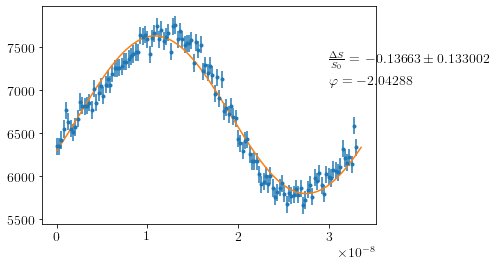

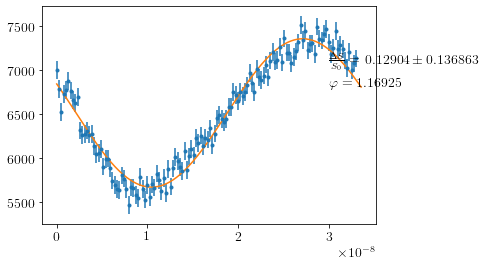

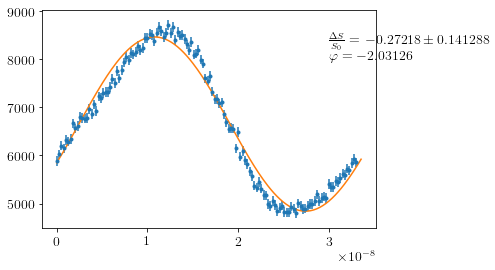

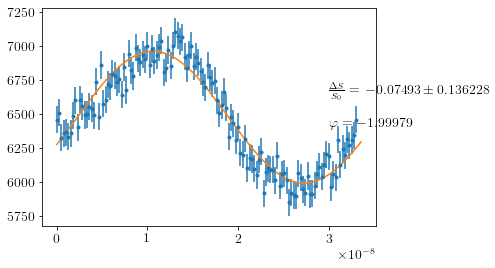

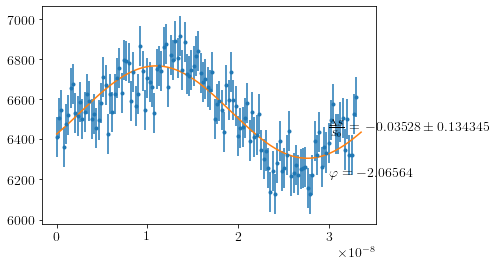

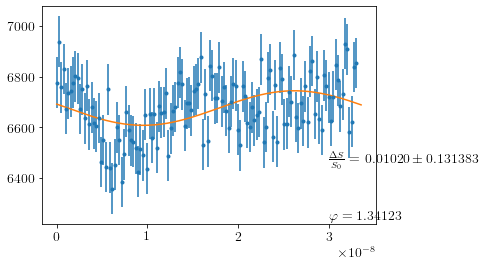

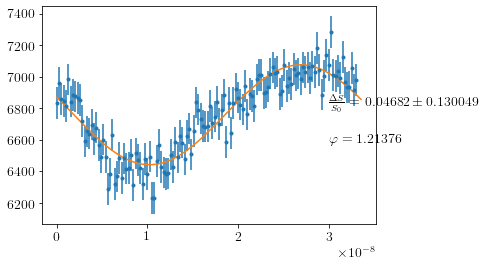

In [62]:
# plot techto fitu
time_fit = np.linspace(0, t_scale.max(), 200)

for i in range(fotkor_shape[1]):
    
    fotkor_fit = fit_func(x[:,i], Omega, time_fit)
    
    plt.figure()
    plt.errorbar(t_scale[:fotkor_shape[0]-2],fotkor[:fotkor_shape[0]-2,i],yerr=1/np.sqrt(W_vec),fmt='.')
    plt.plot(time_fit, fotkor_fit)
    text = r'$\frac{\Delta S}{S_0}  = \,\,$' + r'${:.5f} \pm {:.6f}$'.format(x[1,i]/x[0,i], Delta_S_S_ratio_sigma[i])
    plt.text(3e-8, fotkor[:,i].max()-500,text) 
    text2 = r'$\varphi  = {:.5f}$'.format(fot_phi[i])
    plt.text(3e-8, fotkor[:,i].max()-700,text2) 


In [63]:
my_dpi = 150
siz = 100
sizex = 16*siz
sizey = 9*siz

plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
# plt.errorbar(voltages[:,2], np.abs(DeltaS_S_ratio), yerr=Delta_S_S_ratio_sigma, fmt='.')
plt.plot(voltages[1:,2], np.abs(DeltaS_S_ratio[1:]), '.')
#plt.errorbar(z_bezcond*1e6, DeltaS_S_ratio, yerr=Delta_S_S_ratio_sigma, fmt='.', label="bez kondiku")
plt.xlabel(r"$ U_{\rm komp,\it x} \, \, \rm [V]$")
plt.ylabel(r"$ \frac{\Delta S}{S_0} \, \, \rm [-]$")

plt.grid()

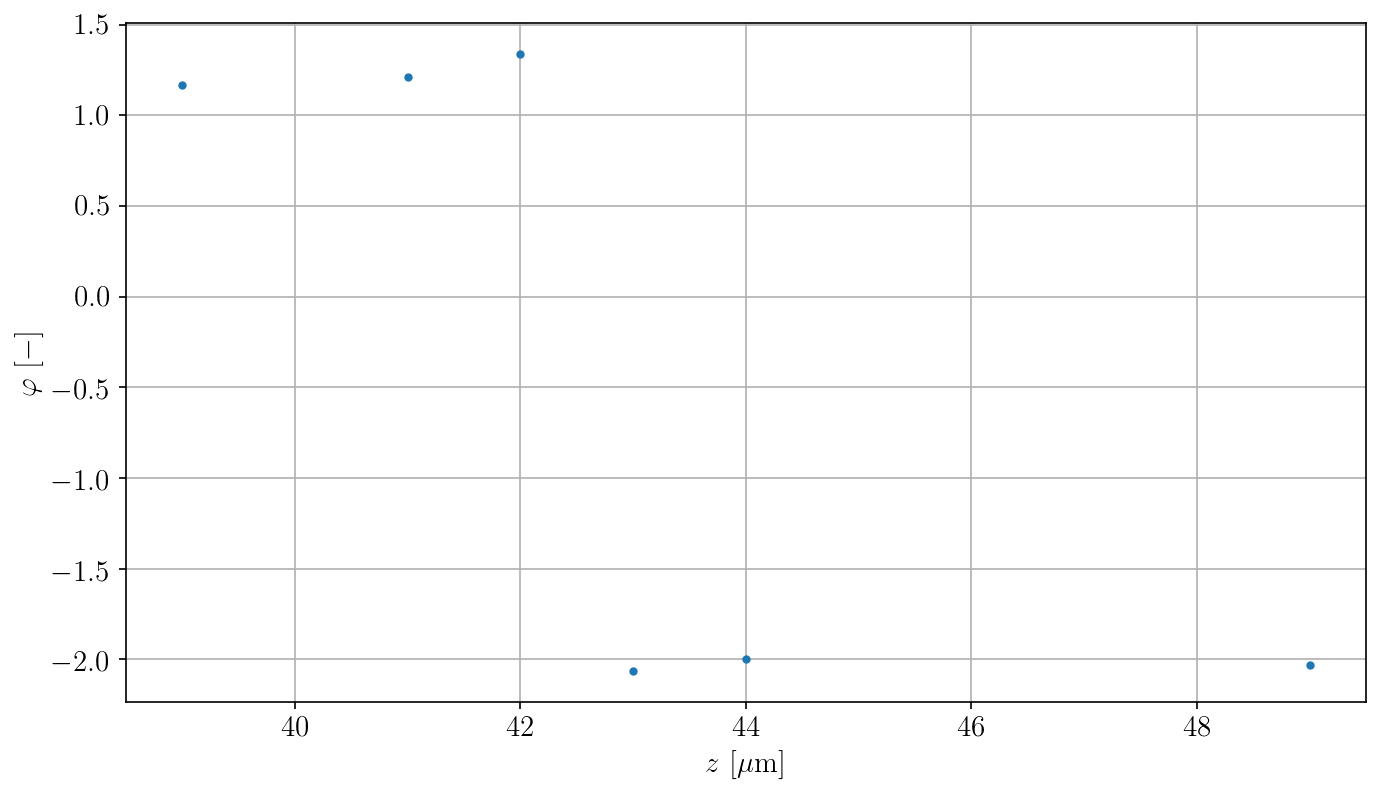

In [73]:
plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
# plt.errorbar(z_bezcond*1e6, fot_phi, yerr=sigmas[2,:], fmt='.', label="bez kondiku")
plt.plot(voltages[1:,2], fot_phi[1:], '.')
#plt.errorbar(z_bezcond*1e6, DeltaS_S_ratio, yerr=Delta_S_S_ratio_sigma, fmt='.', label="bez kondiku")
plt.xlabel(r"$ z \, \, \rm [\mu m]$")
plt.ylabel(r"$ \varphi \, \, \rm [-]$")

# plt.legend()
plt.grid()

In [69]:
print(DeltaS_S_ratio[5])
print(Delta_S_S_ratio_sigma[5])
print(fot_phi[5])
print(sigmas[2,6])

0.01019767436058862
0.13138288644976626
1.3412269587565437
3.920463434842256


In [57]:
np.angle(-DeltaS_S_ratio[5]*np.exp(1j*x[2,5]))

-1.8003656948332496

In [70]:
jac

array([[-1.00000000e-02, -3.49501709e-03,  2.96479991e+00],
       [-1.00000000e-02, -3.03850490e-03,  3.01474662e+00],
       [-1.00000000e-02, -2.57490430e-03,  3.05765829e+00],
       [-1.00000000e-02, -2.10529151e-03,  3.09343688e+00],
       [-1.00000000e-02, -1.63076983e-03,  3.12199790e+00],
       [-1.00000000e-02, -1.15244254e-03,  3.14327447e+00],
       [-1.00000000e-02, -6.71428449e-04,  3.15721680e+00],
       [-1.00000000e-02, -1.88846149e-04,  3.16379323e+00],
       [-1.00000000e-02,  2.94177768e-04,  3.16298815e+00],
       [-1.00000000e-02,  7.76515103e-04,  3.15480357e+00],
       [-1.00000000e-02,  1.25703931e-03,  3.13925762e+00],
       [-1.00000000e-02,  1.73463166e-03,  3.11638747e+00],
       [-1.00000000e-02,  2.20817542e-03,  3.08624646e+00],
       [-1.00000000e-02,  2.67656727e-03,  3.04890398e+00],
       [-1.00000000e-02,  3.13871548e-03,  3.00444852e+00],
       [-1.00000000e-02,  3.59353993e-03,  2.95298266e+00],
       [-1.00000000e-02,  4.03997972e-03

In [67]:
np.sqrt(1.537e1)

3.9204591567825315